<a href="https://colab.research.google.com/github/prasadhegde001/Quora-Question-pair-Similarity/blob/main/Quora_Question_pair_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [59]:
!pip install fuzzywuzzy

### Problem Statement
## 1. Identify which questions asked on Quora are duplicates
## 2. We are tasked to predicting whether pair of questions are duplicate or no

### Metric used for evaluation is Log-loss

#### Source : https://www.kaggle.com/c/quora-question-pairs

In [8]:
# Loading the Dataset
df = pd.read_csv("train.csv")

In [9]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [10]:
df.shape

(404290, 6)

In [11]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

##### Column Question1 and Question2 have missing value, compare to number of the Data we have missing value data is very small
##### so we will be dropping those rows

### Exploratary Data Analysis

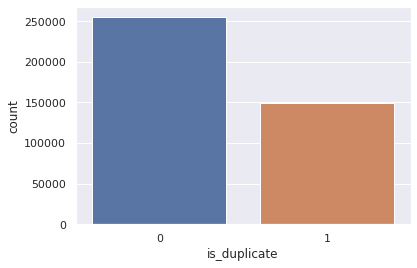

In [12]:
# Histogram of Target variable
sns.set_theme(style="darkgrid")
sns.countplot(x="is_duplicate", data=df)

In [13]:
df["is_duplicate"].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [14]:
df1 = df[df.duplicated("qid1")]

In [15]:
df1

,id,qid1,qid2,question1,question2,is_duplicate
264,264,81,529,Why do Slavs squat?,Do squats work for men?,0
1081,1081,1863,2156,Did Trump win the election?,What do you think of Trump winning the elections?,0
1429,1429,1373,2847,Which are the best movies of 2016?,Which was the best film of 2016?,1
1467,1467,2446,2922,Why do Trump supporters believe that Donald Tr...,Why do you think Donald Trump is getting so mu...,0
1567,1567,1749,3121,How can changing 500 and 1000 rupee notes end ...,Will banning Rs.500 and Rs.1000 notes help to ...,1
...,...,...,...,...,...,...
404276,404276,24305,308365,What is copilotsearch.com?,What is ContenVania.com?,0
404281,404281,99131,81495,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
404282,404282,1931,16773,How does a long distance relationship work?,How are long distance relationships maintained?,1
404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0


In [16]:
## Number of unique questions
qids = pd.Series(df["qid1"].tolist()+ df["qid2"].tolist())

In [17]:
qids

0              1
1              3
2              5
3              7
4              9
           ...  
808575    379845
808576    155606
808577    537929
808578    537931
808579    537933
Length: 808580, dtype: int64

In [18]:
unique_qs = len(np.unique(qids))

In [19]:
unique_qs

537933

##### There are 537933 unique questions

In [20]:
more_one_time = np.sum(qids.value_counts() > 1)

In [21]:
more_one_time

111780

#### Max number of times a single question is repeated

In [22]:
print(f"Max number of times a single question is repeated {max(qids.value_counts())}")

Max number of times a single question is repeated 157


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


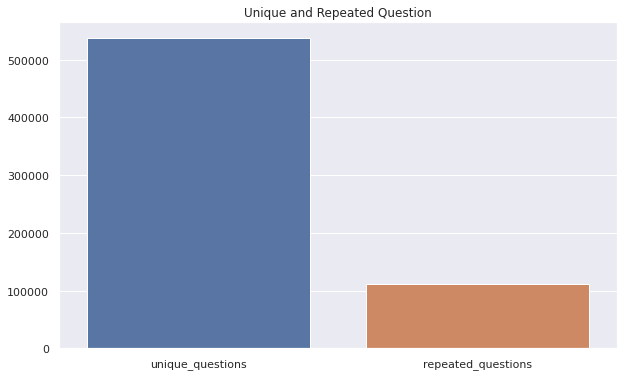

In [23]:
# Histogram of unique question and repeated questions
x = ["unique_questions", "repeated_questions"]
y = [unique_qs, more_one_time]
plt.figure(figsize=(10, 6))
plt.title("Unique and Repeated Question")
sns.barplot(x,y)

In [24]:
## Checking whether any repeated pair of questions
pair_duplicate = df[["qid1","qid2", "is_duplicate"]].groupby(["qid1","qid2"]).count().reset_index()
print(f"Number of duplicate entries {pair_duplicate.shape[0] - df.shape[0]}")

Number of duplicate entries 0


In [25]:
pair_duplicate = df[df.duplicated(["qid1","qid2", "is_duplicate"])]

In [26]:
len(pair_duplicate)

0

### Numbe of occurence of each question

(array([4.26153e+05, 6.47670e+04, 2.12260e+04, 9.34500e+03, 4.86500e+03,
        2.84600e+03, 1.84200e+03, 1.30800e+03, 9.29000e+02, 6.93000e+02,
        5.78000e+02, 4.80000e+02, 3.87000e+02, 3.21000e+02, 2.70000e+02,
        1.99000e+02, 1.92000e+02, 1.87000e+02, 1.53000e+02, 1.54000e+02,
        1.13000e+02, 1.03000e+02, 1.05000e+02, 8.80000e+01, 7.50000e+01,
        5.80000e+01, 6.60000e+01, 4.70000e+01, 3.20000e+01, 3.00000e+01,
        3.50000e+01, 3.60000e+01, 3.90000e+01, 2.00000e+01, 1.80000e+01,
        1.10000e+01, 1.20000e+01, 1.20000e+01, 7.00000e+00, 0.00000e+00,
        8.00000e+00, 2.00000e+01, 1.50000e+01, 1.00000e+01, 8.00000e+00,
        8.00000e+00, 8.00000e+00, 5.00000e+00, 3.00000e+00, 9.00000e+00,
        5.00000e+00, 7.00000e+00, 3.00000e+00, 1.00000e+00, 4.00000e+00,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00

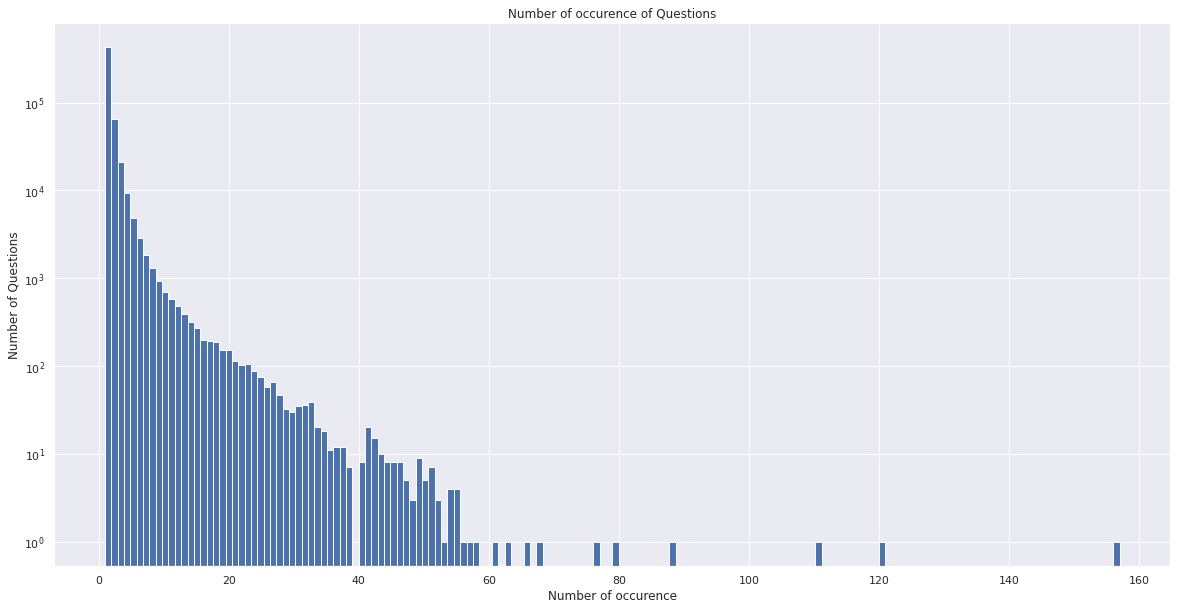

In [27]:
plt.figure(figsize=(20, 10))
plt.title("Number of occurence of Questions")
plt.xlabel("Number of occurence")
plt.ylabel("Number of Questions")
plt.yscale("log", nonposy="clip")
plt.hist(qids.value_counts(), bins=160)

In [28]:
# Dropping NA rows
df.shape

(404290, 6)

In [29]:
df.dropna(inplace=True)
df.shape

(404287, 6)

## Feature Engineering
#### Constructing new features from given dataset

##### freq_qid1 = Frequency of qid1's
##### freq_qid2 = Frequency of qid2's
##### q1len = Length of q1
##### q2len = Length of q2
##### q1_n_words = Number of words in Question 1
##### q2_n_words = Number of words in Question 2
##### word_Common = (Number of common unique words in Question 1 and Question 2)
##### word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
##### word_share = (word_common)/(word_Total)
##### freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

In [30]:
# Creating Frequency column
df["freq_qid1"] = df.groupby("qid1")["qid1"].transform("count")
df["freq_qid2"] = df.groupby("qid2")["qid2"].transform("count")

In [31]:
# Creating q1len and q2len column
df['q1len'] = df["question1"].str.len()
df["q2len"] = df["question2"].str.len()

In [32]:
# Creating q1_n_words and q2_n_words column
df["q1_n_words"] = df["question1"].apply(lambda row: len(row.split(" ")))
df["q2_n_words"] = df["question2"].apply(lambda row: len(row.split(" ")))

In [33]:
# Creating word_common column
def normalized_word_common(row):
    w1 = set(map(lambda word : word.lower().strip(), row["question1"].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row["question2"].split(" ")))
    return 1.0 * len(w1 & w2)

df["word_Common"] = df.apply(normalized_word_common,axis=1)

In [34]:
# Creating word_total column
def normalized_word_total(row):
    w1 = set(map(lambda word: word.lower().strip(), row["question1"].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row["question2"].split(" ")))
    return 1.0 * (len(w1) + len(w2))
df["word_Total"] = df.apply(normalized_word_total, axis=1)

In [35]:
# Creating word_share column
def normalized_word_share(row): 
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

In [36]:
# creating freq_q1+freq_q2 column
df["freq_q1+freq_q2"] = df["freq_qid1"] + df["freq_qid2"]

In [37]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


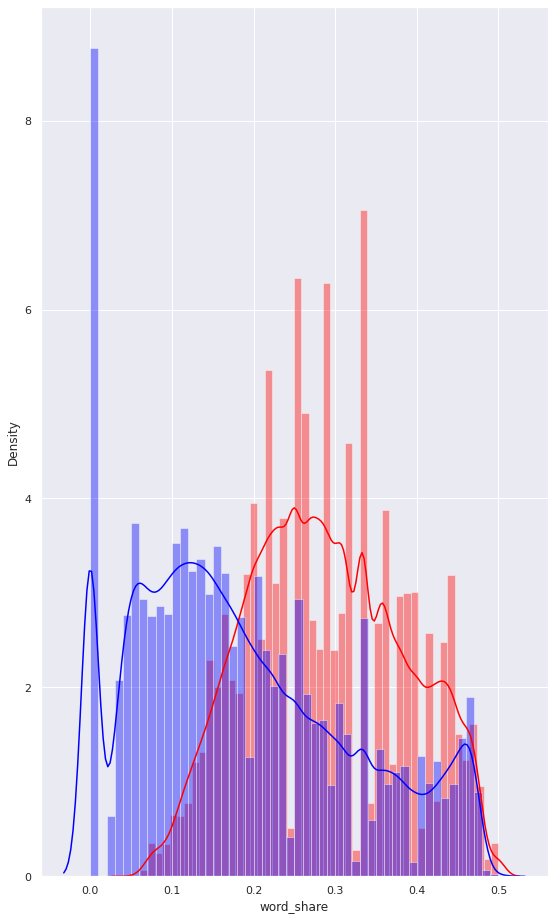

In [40]:
#EDA on word_share column
plt.figure(figsize=(20, 16))
plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

In [41]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [42]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x

# Text Pre-processing

### Advance Feature Engineering

##### cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2
##### cwc_min = common_word_count / (min(len(q1_words), len(q2_words))

##### cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2
##### cwc_max = common_word_count / (max(len(q1_words), len(q2_words))

##### last_word_eq : Check if First word of both questions is equal or not
##### last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])

##### first_word_eq : Check if First word of both questions is equal or not
##### first_word_eq = int(q1_tokens[0] == q2_tokens[0])

##### Fuzzy_ratio
##### Fuzzy_partial_ratio
##### token_sort_ratio
##### token_set_ratio


In [55]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset

    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [56]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2
3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2
4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,3,1,76,39,13,7,2.0,20.0,0.100000,4


In [64]:
df = extract_features(df)

token features...
fuzzy features..


KeyboardInterrupt: ignored

In [70]:
# Creating WordCloud for duplicate and non-duplicate word
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

In [66]:
p

array(['astrology  i am a capricorn sun cap moon and cap rising   what does that say about me ',
       'i am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me ',
       'how can i be a good geologist ', ...,
       'what does jainism say about gays and homosexuality ',
       'do you believe there is life after death ',
       'is it true that there is life after death '], dtype=object)

In [71]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109860
Total number of words in non duplicate pair questions : 33192755


Word Cloud for Duplicate Question pairs


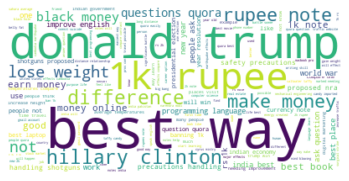

In [72]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


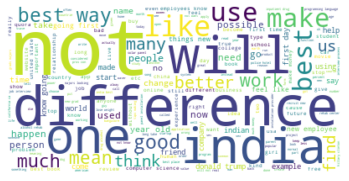

In [73]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()